# Feature Extration

In [1]:
import os
import librosa
import pywt
import numpy as np
from tqdm import tqdm
import scipy.stats

# Function to preprocess audio (mono and normalize)
def preprocess_audio(file_path, target_sr=22050):
    # Load audio as mono and resample to target sample rate
    y, sr = librosa.load(file_path, sr=target_sr, mono=True)

    # Normalize the audio
    y = y / np.max(np.abs(y))

    return y, sr

# Function to extract Mel-Spectrogram and MFCC features
def extract_mel_mfcc(file_path, sr=22050, n_mels=128, n_mfcc=20):
    # Preprocess the audio
    y, sr = preprocess_audio(file_path, sr)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel_spec), n_mfcc=n_mfcc)
    return mel_spec, mfcc

# Function to extract DWT-based statistical features
def extract_dwt_features(file_path, wavelet='db4', level=5, fixed_size=250):
    # Preprocess the audio
    y, sr = preprocess_audio(file_path)

    coeffs = pywt.wavedec(y, wavelet, level=level)
    features = []
    for c in coeffs:
        stats = [np.mean(c), np.var(c), np.std(c),
                 np.mean(np.abs(c)), np.mean(c**2),
                 scipy.stats.skew(c), scipy.stats.entropy(np.abs(c))]
        features.extend(stats)

    # Ensure fixed size (truncate or pad as needed)
    if len(features) > fixed_size:
        features = features[:fixed_size]  # Truncate to fixed_size
    else:
        features = np.pad(features, (0, fixed_size - len(features)), 'constant')  # Pad with zeros
    return np.array(features)

# Function to process training data
def process_training_data(train_dir, save_path):
    feature_data = []
    labels = []
    for subdir in os.listdir(train_dir):
        subfolder_path = os.path.join(train_dir, subdir)
        if os.path.isdir(subfolder_path):
            for file in tqdm(os.listdir(subfolder_path), desc=f"Processing {subdir}"):
                if file.endswith(".wav"):
                    file_path = os.path.join(subfolder_path, file)
                    mel_spec, mfcc = extract_mel_mfcc(file_path)
                    dwt_features = extract_dwt_features(file_path)
                    label = subdir  # Subfolder name as the label
                    feature_data.append({'mel_spec': mel_spec, 'mfcc': mfcc, 'dwt': dwt_features})
                    labels.append(label)
    np.savez(save_path, features=feature_data, labels=labels)

# Function to process testing data
def process_testing_data(test_dir, save_path):
    feature_data = []
    labels = []
    for file in tqdm(os.listdir(test_dir), desc="Processing Test Data"):
        if file.endswith(".wav"):
            file_path = os.path.join(test_dir, file)
            txt_file_path = os.path.splitext(file_path)[0] + ".txt"
            mel_spec, mfcc = extract_mel_mfcc(file_path)
            dwt_features = extract_dwt_features(file_path)

            # Read labels from the corresponding .txt file
            with open(txt_file_path, "r") as txt_file:
                file_labels = txt_file.read().splitlines()  # Multi-labels
            feature_data.append({'mel_spec': mel_spec, 'mfcc': mfcc, 'dwt': dwt_features})
            labels.append(file_labels)
    np.savez(save_path, features=feature_data, labels=labels)

# Process training and testing data
train_dir = "./../../../IRMAS/IRMAS-TrainingData"
test_dir_part1 = "./../../../IRMAS/IRMAS-TestingData-Part1"
test_dir_part2 = "./../../../IRMAS/IRMAS-TestingData-Part2"

# Save paths
save_path_train = "train_features.npz"
save_path_test_part1 = "test_features_part1.npz"
save_path_test_part2 = "test_features_part2.npz"

# Process and save
process_training_data(train_dir, save_path_train)
process_testing_data(test_dir_part1, save_path_test_part1)
process_testing_data(test_dir_part2, save_path_test_part2)

Processing Test Data: 100%|██████████| 3/3 [00:00<00:00, 13781.94it/s]


# Data Preparation


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Custom Dataset class for IRMAS
class IRMASDataset(Dataset):
    def __init__(self, feature_file, train=True, transform=None):
        # Load features and labels
        data = np.load(feature_file, allow_pickle=True)
        self.features = data['features']
        self.labels = data['labels']

        # Encode labels for training data (single-label encoding)
        le = LabelEncoder()
        if isinstance(self.labels[0], list):  # Multi-label for testing data
            self.labels = [le.fit_transform(label) for label in self.labels]
        else:  # Single-label for training data
            self.labels = le.fit_transform(self.labels)
        self.label_mapping = dict(zip(le.classes_, range(len(le.classes_))))

        # Split into train and validation sets
        if train:
            self.data, _, self.targets, _ = train_test_split(
                self.features, self.labels, test_size=0.2, random_state=42)
        else:
            _, self.data, _, self.targets = train_test_split(
                self.features, self.labels, test_size=0.2, random_state=42)

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        mel_spec = sample['mel_spec']
        mfcc = sample['mfcc']
        dwt = sample['dwt']
        label = self.targets[idx]

        # Apply transformations if provided
        if self.transform:
            mel_spec = self.transform(mel_spec)
            mfcc = self.transform(mfcc)
            dwt = self.transform(dwt)

        # Convert features to tensors
        mel_spec_tensor = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0)
        mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0)
        dwt_tensor = torch.tensor(dwt, dtype=torch.float32)

        return (mel_spec_tensor, mfcc_tensor, dwt_tensor), torch.tensor(label, dtype=torch.long)

# Create DataLoaders
def create_dataloaders(feature_file, batch_size=32):
    train_dataset = IRMASDataset(feature_file, train=True)
    val_dataset = IRMASDataset(feature_file, train=False)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, train_dataset.label_mapping

# Example usage
train_feature_file = "train_features.npz"
batch_size = 512
train_loader, val_loader, label_mapping = create_dataloaders(train_feature_file, batch_size)

# Print label mapping
print("Label mapping:", label_mapping)

Label mapping: {'cel': 0, 'cla': 1, 'flu': 2, 'gac': 3, 'gel': 4, 'org': 5, 'pia': 6, 'sax': 7, 'tru': 8, 'vio': 9, 'voi': 10}


# Deep CNN Model


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the Deep Convolutional Neural Network (CNN)
class IRMASModel(nn.Module):
    def __init__(self, num_classes):
        super(IRMASModel, self).__init__()
        
        # CNN pathway for Mel-Spectrogram and MFCC
        self.cnn_path = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(0.25),
            nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        )
        
        # Dense pathway for DWT features
        self.dwt_path = nn.Sequential(
            nn.Linear(250, 64),  # Match the input features (35 from DWT extraction)
            nn.ReLU()
        )
        
        # Combined dense layers
        self.fc = nn.Sequential(
            nn.Linear(256 + 64, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        mel_spec, mfcc, dwt = x

        # Process Mel-Spectrogram and MFCC features through CNN
        mel_spec_out = self.cnn_path(mel_spec)
        mfcc_out = self.cnn_path(mfcc)

        # Flatten the outputs
        mel_spec_out = mel_spec_out.view(mel_spec_out.size(0), -1)  # Batch x Flattened Size
        mfcc_out = mfcc_out.view(mfcc_out.size(0), -1)

        # Combine Mel-Spectrogram and MFCC outputs
        combined_cnn_out = mel_spec_out + mfcc_out

        # Process DWT features through Dense Pathway
        dwt = dwt.view(dwt.size(0), -1)  # Ensure DWT has shape Batch x Feature Size (35 features)
        dwt_out = self.dwt_path(dwt)

        # Combine CNN and DWT features
        combined_features = torch.cat((combined_cnn_out, dwt_out), dim=1)

        # Final classification layers
        out = self.fc(combined_features)

        return out

# Instantiate the model
num_classes = 11  # Number of instrument classes in IRMAS dataset
model = IRMASModel(num_classes)

# Print model summary
print(model)

IRMASModel(
  (cnn_path): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.25, inplace=False)
    (15): Conv2d(64, 128, kernel_size=(3, 3), 

# Training

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os

# Training function
def train_model(model, train_loader, val_loader, num_epochs, device, save_dir):
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)
    
    # Move model to the device
    model = model.to(device)
    
    # Track accuracy and loss
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = [x.to(device) for x in inputs]
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs = [x.to(device) for x in inputs]
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate validation accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct / total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Print results
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Adjust learning rate
        # scheduler.step(val_loss)

        # Save model and history
        torch.save(model.state_dict(), os.path.join(save_dir, f"model_epoch_{epoch + 1}.pth"))
        torch.save(history, os.path.join(save_dir, "history.pth"))

    return history

# Set up device and directories
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current Training Session is Running on: ", device)
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Load data
train_feature_file = "train_features.npz"
batch_size = 512
train_loader, val_loader, label_mapping = create_dataloaders(train_feature_file, batch_size)

# Train the model
num_epochs = 100
history = train_model(model, train_loader, val_loader, num_epochs, device, save_dir)

Current Training Session is Running on:  cuda
Epoch 1/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.39it/s]


Train Loss: 1.6697, Train Acc: 0.8768
Val Loss: 2.3255, Val Acc: 0.2125
Epoch 2/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.09it/s]


Train Loss: 1.6719, Train Acc: 0.8768
Val Loss: 2.3215, Val Acc: 0.2177
Epoch 3/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.50it/s]


Train Loss: 1.6627, Train Acc: 0.8835
Val Loss: 2.3320, Val Acc: 0.2036
Epoch 4/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.72it/s]


Train Loss: 1.6630, Train Acc: 0.8842
Val Loss: 2.3287, Val Acc: 0.2058
Epoch 5/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.00it/s]


Train Loss: 1.6544, Train Acc: 0.8917
Val Loss: 2.3309, Val Acc: 0.2043
Epoch 6/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.65it/s]


Train Loss: 1.6601, Train Acc: 0.8876
Val Loss: 2.3197, Val Acc: 0.2148
Epoch 7/100


Validation: 100%|██████████| 3/3 [00:00<00:00,  9.65it/s]


Train Loss: 1.6588, Train Acc: 0.8874
Val Loss: 2.3194, Val Acc: 0.2185
Epoch 8/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.49it/s]


Train Loss: 1.6589, Train Acc: 0.8844
Val Loss: 2.3098, Val Acc: 0.2274
Epoch 9/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.80it/s]


Train Loss: 1.6569, Train Acc: 0.8874
Val Loss: 2.3125, Val Acc: 0.2245
Epoch 10/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.10it/s]


Train Loss: 1.6544, Train Acc: 0.8898
Val Loss: 2.3114, Val Acc: 0.2252
Epoch 11/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.92it/s]


Train Loss: 1.6479, Train Acc: 0.8971
Val Loss: 2.3134, Val Acc: 0.2237
Epoch 12/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.24it/s]


Train Loss: 1.6508, Train Acc: 0.8958
Val Loss: 2.3079, Val Acc: 0.2297
Epoch 13/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.56it/s]


Train Loss: 1.6513, Train Acc: 0.8937
Val Loss: 2.3044, Val Acc: 0.2349
Epoch 14/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.74it/s]


Train Loss: 1.6503, Train Acc: 0.8969
Val Loss: 2.3039, Val Acc: 0.2364
Epoch 15/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.06it/s]


Train Loss: 1.6485, Train Acc: 0.8960
Val Loss: 2.2985, Val Acc: 0.2401
Epoch 16/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.41it/s]


Train Loss: 1.6479, Train Acc: 0.8973
Val Loss: 2.3000, Val Acc: 0.2364
Epoch 17/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.23it/s]


Train Loss: 1.6513, Train Acc: 0.8950
Val Loss: 2.2999, Val Acc: 0.2364
Epoch 18/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.48it/s]


Train Loss: 1.6488, Train Acc: 0.8958
Val Loss: 2.3052, Val Acc: 0.2297
Epoch 19/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.17it/s]


Train Loss: 1.6469, Train Acc: 0.9003
Val Loss: 2.3140, Val Acc: 0.2215
Epoch 20/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.76it/s]


Train Loss: 1.6495, Train Acc: 0.8984
Val Loss: 2.3096, Val Acc: 0.2267
Epoch 21/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.48it/s]


Train Loss: 1.6465, Train Acc: 0.8971
Val Loss: 2.3120, Val Acc: 0.2252
Epoch 22/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.08it/s]


Train Loss: 1.6449, Train Acc: 0.9018
Val Loss: 2.3202, Val Acc: 0.2177
Epoch 23/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.57it/s]


Train Loss: 1.6499, Train Acc: 0.8986
Val Loss: 2.3228, Val Acc: 0.2163
Epoch 24/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.81it/s]


Train Loss: 1.6432, Train Acc: 0.9016
Val Loss: 2.3209, Val Acc: 0.2170
Epoch 25/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.40it/s]


Train Loss: 1.6443, Train Acc: 0.9029
Val Loss: 2.3186, Val Acc: 0.2207
Epoch 26/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.58it/s]


Train Loss: 1.6422, Train Acc: 0.9023
Val Loss: 2.3125, Val Acc: 0.2252
Epoch 27/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.73it/s]


Train Loss: 1.6455, Train Acc: 0.9004
Val Loss: 2.3111, Val Acc: 0.2252
Epoch 28/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.89it/s]


Train Loss: 1.6428, Train Acc: 0.9016
Val Loss: 2.3097, Val Acc: 0.2252
Epoch 29/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.67it/s]


Train Loss: 1.6458, Train Acc: 0.8997
Val Loss: 2.3147, Val Acc: 0.2222
Epoch 30/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.65it/s]


Train Loss: 1.6405, Train Acc: 0.9055
Val Loss: 2.3151, Val Acc: 0.2215
Epoch 31/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.61it/s]


Train Loss: 1.6408, Train Acc: 0.9047
Val Loss: 2.3106, Val Acc: 0.2237
Epoch 32/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.87it/s]


Train Loss: 1.6437, Train Acc: 0.9036
Val Loss: 2.3107, Val Acc: 0.2245
Epoch 33/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.89it/s]


Train Loss: 1.6381, Train Acc: 0.9059
Val Loss: 2.3190, Val Acc: 0.2163
Epoch 34/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.53it/s]


Train Loss: 1.6419, Train Acc: 0.9053
Val Loss: 2.3202, Val Acc: 0.2140
Epoch 35/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.14it/s]


Train Loss: 1.6423, Train Acc: 0.9018
Val Loss: 2.3114, Val Acc: 0.2237
Epoch 36/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.86it/s]


Train Loss: 1.6375, Train Acc: 0.9077
Val Loss: 2.3121, Val Acc: 0.2215
Epoch 37/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.51it/s]


Train Loss: 1.6408, Train Acc: 0.9064
Val Loss: 2.3109, Val Acc: 0.2252
Epoch 38/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.82it/s]


Train Loss: 1.6367, Train Acc: 0.9088
Val Loss: 2.3156, Val Acc: 0.2215
Epoch 39/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.70it/s]


Train Loss: 1.6411, Train Acc: 0.9051
Val Loss: 2.3194, Val Acc: 0.2163
Epoch 40/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.21it/s]


Train Loss: 1.6398, Train Acc: 0.9051
Val Loss: 2.3260, Val Acc: 0.2110
Epoch 41/100


Validation: 100%|██████████| 3/3 [00:00<00:00,  9.32it/s]


Train Loss: 1.6381, Train Acc: 0.9079
Val Loss: 2.3192, Val Acc: 0.2148
Epoch 42/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.74it/s]


Train Loss: 1.6400, Train Acc: 0.9064
Val Loss: 2.3176, Val Acc: 0.2177
Epoch 43/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.12it/s]


Train Loss: 1.6381, Train Acc: 0.9070
Val Loss: 2.3167, Val Acc: 0.2192
Epoch 44/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.78it/s]


Train Loss: 1.6388, Train Acc: 0.9077
Val Loss: 2.3146, Val Acc: 0.2207
Epoch 45/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.58it/s]


Train Loss: 1.6409, Train Acc: 0.9034
Val Loss: 2.3195, Val Acc: 0.2155
Epoch 46/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.90it/s]


Train Loss: 1.6387, Train Acc: 0.9066
Val Loss: 2.3173, Val Acc: 0.2170
Epoch 47/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.71it/s]


Train Loss: 1.6379, Train Acc: 0.9070
Val Loss: 2.3153, Val Acc: 0.2192
Epoch 48/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.43it/s]


Train Loss: 1.6392, Train Acc: 0.9073
Val Loss: 2.3182, Val Acc: 0.2185
Epoch 49/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.70it/s]


Train Loss: 1.6371, Train Acc: 0.9077
Val Loss: 2.3132, Val Acc: 0.2207
Epoch 50/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.88it/s]


Train Loss: 1.6373, Train Acc: 0.9087
Val Loss: 2.3179, Val Acc: 0.2192
Epoch 51/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.01it/s]


Train Loss: 1.6401, Train Acc: 0.9040
Val Loss: 2.3167, Val Acc: 0.2215
Epoch 52/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.86it/s]


Train Loss: 1.6367, Train Acc: 0.9098
Val Loss: 2.3206, Val Acc: 0.2163
Epoch 53/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.82it/s]


Train Loss: 1.6353, Train Acc: 0.9118
Val Loss: 2.3224, Val Acc: 0.2170
Epoch 54/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.94it/s]


Train Loss: 1.6369, Train Acc: 0.9088
Val Loss: 2.3215, Val Acc: 0.2177
Epoch 55/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.39it/s]


Train Loss: 1.6336, Train Acc: 0.9094
Val Loss: 2.3203, Val Acc: 0.2185
Epoch 56/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.62it/s]


Train Loss: 1.6354, Train Acc: 0.9128
Val Loss: 2.3211, Val Acc: 0.2170
Epoch 57/100


Validation: 100%|██████████| 3/3 [00:00<00:00,  9.37it/s]


Train Loss: 1.6340, Train Acc: 0.9114
Val Loss: 2.3235, Val Acc: 0.2155
Epoch 58/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.78it/s]


Train Loss: 1.6363, Train Acc: 0.9059
Val Loss: 2.3286, Val Acc: 0.2103
Epoch 59/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.28it/s]


Train Loss: 1.6346, Train Acc: 0.9111
Val Loss: 2.3181, Val Acc: 0.2185
Epoch 60/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.84it/s]


Train Loss: 1.6371, Train Acc: 0.9090
Val Loss: 2.3196, Val Acc: 0.2185
Epoch 61/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.65it/s]


Train Loss: 1.6291, Train Acc: 0.9159
Val Loss: 2.3221, Val Acc: 0.2140
Epoch 62/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.63it/s]


Train Loss: 1.6336, Train Acc: 0.9126
Val Loss: 2.3201, Val Acc: 0.2177
Epoch 63/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.68it/s]


Train Loss: 1.6330, Train Acc: 0.9116
Val Loss: 2.3194, Val Acc: 0.2185
Epoch 64/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.35it/s]


Train Loss: 1.6315, Train Acc: 0.9154
Val Loss: 2.3130, Val Acc: 0.2260
Epoch 65/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.74it/s]


Train Loss: 1.6303, Train Acc: 0.9135
Val Loss: 2.3152, Val Acc: 0.2252
Epoch 66/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.85it/s]


Train Loss: 1.6330, Train Acc: 0.9120
Val Loss: 2.3160, Val Acc: 0.2245
Epoch 67/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.93it/s]


Train Loss: 1.6343, Train Acc: 0.9129
Val Loss: 2.3159, Val Acc: 0.2237
Epoch 68/100


Validation: 100%|██████████| 3/3 [00:00<00:00,  9.38it/s]


Train Loss: 1.6295, Train Acc: 0.9154
Val Loss: 2.3116, Val Acc: 0.2252
Epoch 69/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.81it/s]


Train Loss: 1.6325, Train Acc: 0.9120
Val Loss: 2.3205, Val Acc: 0.2170
Epoch 70/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.18it/s]


Train Loss: 1.6300, Train Acc: 0.9144
Val Loss: 2.3191, Val Acc: 0.2155
Epoch 71/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.68it/s]


Train Loss: 1.6331, Train Acc: 0.9085
Val Loss: 2.3218, Val Acc: 0.2140
Epoch 72/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.91it/s]


Train Loss: 1.6297, Train Acc: 0.9150
Val Loss: 2.3240, Val Acc: 0.2118
Epoch 73/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.96it/s]


Train Loss: 1.6315, Train Acc: 0.9154
Val Loss: 2.3237, Val Acc: 0.2133
Epoch 74/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.40it/s]


Train Loss: 1.6306, Train Acc: 0.9133
Val Loss: 2.3236, Val Acc: 0.2155
Epoch 75/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.39it/s]


Train Loss: 1.6331, Train Acc: 0.9141
Val Loss: 2.3181, Val Acc: 0.2192
Epoch 76/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 12.24it/s]


Train Loss: 1.6288, Train Acc: 0.9183
Val Loss: 2.3168, Val Acc: 0.2207
Epoch 77/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.91it/s]


Train Loss: 1.6330, Train Acc: 0.9111
Val Loss: 2.3126, Val Acc: 0.2230
Epoch 78/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.39it/s]


Train Loss: 1.6306, Train Acc: 0.9128
Val Loss: 2.3095, Val Acc: 0.2274
Epoch 79/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.65it/s]


Train Loss: 1.6281, Train Acc: 0.9167
Val Loss: 2.3017, Val Acc: 0.2364
Epoch 80/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.70it/s]


Train Loss: 1.6311, Train Acc: 0.9144
Val Loss: 2.3044, Val Acc: 0.2312
Epoch 81/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.67it/s]


Train Loss: 1.6268, Train Acc: 0.9196
Val Loss: 2.3033, Val Acc: 0.2342
Epoch 82/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.28it/s]


Train Loss: 1.6302, Train Acc: 0.9150
Val Loss: 2.3004, Val Acc: 0.2364
Epoch 83/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 10.66it/s]


Train Loss: 1.6269, Train Acc: 0.9178
Val Loss: 2.3019, Val Acc: 0.2342
Epoch 84/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.99it/s]


Train Loss: 1.6314, Train Acc: 0.9135
Val Loss: 2.2992, Val Acc: 0.2401
Epoch 85/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.51it/s]


Train Loss: 1.6312, Train Acc: 0.9135
Val Loss: 2.3006, Val Acc: 0.2364
Epoch 86/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.92it/s]


Train Loss: 1.6285, Train Acc: 0.9161
Val Loss: 2.3055, Val Acc: 0.2282
Epoch 87/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.96it/s]


Train Loss: 1.6279, Train Acc: 0.9161
Val Loss: 2.3082, Val Acc: 0.2282
Epoch 88/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.61it/s]


Train Loss: 1.6267, Train Acc: 0.9185
Val Loss: 2.3025, Val Acc: 0.2319
Epoch 89/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.75it/s]


Train Loss: 1.6285, Train Acc: 0.9161
Val Loss: 2.3091, Val Acc: 0.2252
Epoch 90/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.99it/s]


Train Loss: 1.6259, Train Acc: 0.9191
Val Loss: 2.3126, Val Acc: 0.2222
Epoch 91/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.99it/s]


Train Loss: 1.6270, Train Acc: 0.9183
Val Loss: 2.3163, Val Acc: 0.2192
Epoch 92/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.47it/s]


Train Loss: 1.6264, Train Acc: 0.9169
Val Loss: 2.3167, Val Acc: 0.2207
Epoch 93/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.83it/s]


Train Loss: 1.6264, Train Acc: 0.9185
Val Loss: 2.3163, Val Acc: 0.2200
Epoch 94/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.90it/s]


Train Loss: 1.6289, Train Acc: 0.9163
Val Loss: 2.3138, Val Acc: 0.2222
Epoch 95/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.87it/s]


Train Loss: 1.6262, Train Acc: 0.9185
Val Loss: 2.3140, Val Acc: 0.2222
Epoch 96/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.83it/s]


Train Loss: 1.6292, Train Acc: 0.9167
Val Loss: 2.3150, Val Acc: 0.2215
Epoch 97/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.85it/s]


Train Loss: 1.6257, Train Acc: 0.9196
Val Loss: 2.3139, Val Acc: 0.2230
Epoch 98/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.53it/s]


Train Loss: 1.6255, Train Acc: 0.9196
Val Loss: 2.3125, Val Acc: 0.2267
Epoch 99/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.72it/s]


Train Loss: 1.6280, Train Acc: 0.9155
Val Loss: 2.3107, Val Acc: 0.2260
Epoch 100/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 11.64it/s]

Train Loss: 1.6256, Train Acc: 0.9213
Val Loss: 2.3079, Val Acc: 0.2319


# Accuracy and Loss

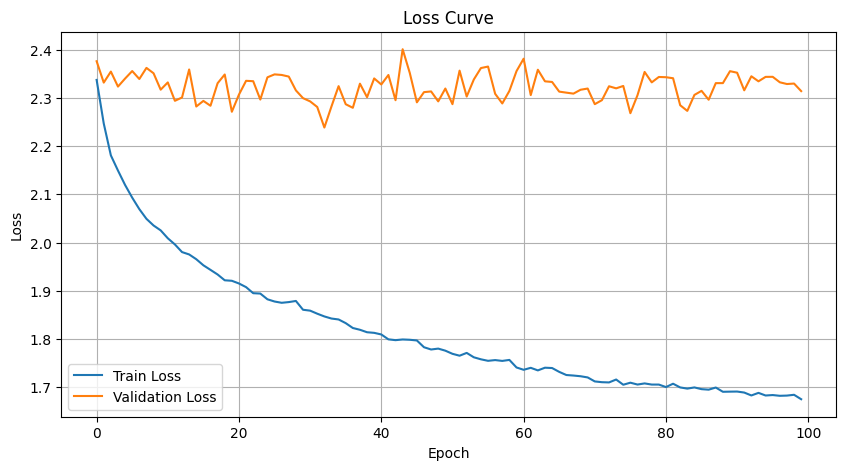

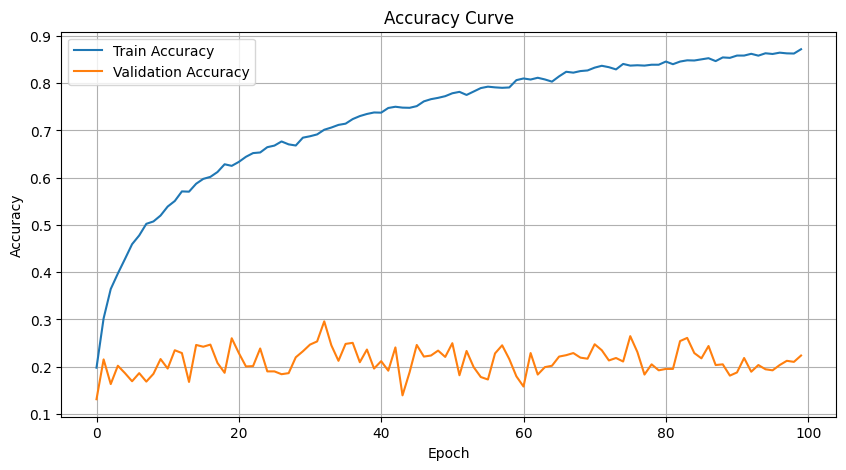

In [7]:
import torch
import matplotlib.pyplot as plt

# Load training history
history_path = "saved_models/history.pth"
history = torch.load(history_path)

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Testset Evaluation

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Load the test features and labels
test_feature_file = "test_features_part1.npz"  # Use Part1 or Part2 as needed
test_dataset = IRMASDataset(test_feature_file, train=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the trained model
model_path = "saved_models/model_epoch_20.pth"  # Use the best epoch
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

# Evaluate the model on the test set
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = [x.to(device) for x in inputs]
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Store predictions and true labels
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate performance metrics
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=list(label_mapping.keys())))

IndexError: index 0 is out of bounds for axis 0 with size 0